In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import glob
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# VEST NJ 2017

## VEST's Documentation File

Election results from individual county canvass reports or election reporting websites (https://nj.gov/state/elections/vote-county-election-officials.shtml).   
  
Note that the precinct results from Warren County include 5 votes for Phil Murphy (D) and 23 votes for Kim Guadagno (R) that are not in the official state results. These 28 votes total are from Liberty Township.  
  
Precinct shapefile from New Jersey Geographic Information Network (https://njogis-newjersey.opendata.arcgis.com/datasets/election-districts-for-new-jersey). Naval Weapons Station Earle in Monmouth County was added as an unassigned district.  

All counties except Middlesex, Sussex, and Warren report mail votes and provisional votes at the municipal and/or ward level. Essex County further subdivides these vote types by other districts on the same ballot. All votes were distributed by candidate to precincts based on their share of the precinct-level reported vote of the respective reporting unit.  
  
The following modifications to the shapefile were made to reverse changes in precinct boundaries enacted since 2017:  
  
Hudson: Merge Jersey City Ward E 9/24, 6/25; Realign Union City Ward 9 precincts  
Passaic: Merge Pompton Lakes 3/6  
  
G17GOVDMUR - Philip Murphy (Democratic Party)  
G17GOVRGUA - Kim Guadagno (Republican Party)  
G17GOVLROH - Peter J. Rohrman (Libertarian Party)  
G17GOVGKAP - Seth Kaper-Dale (Green Party)  
G17GOVCRIC - Matthew Riccardi (Constitution Party)  
G17GOVOGEN - Gina Genovese (Reduce Property Taxes)  
G17GOVOROS - Vincent Ross (We the People)  

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nj_2017/nj_2017.shp")

In [3]:
vest_shp.shape

(6344, 18)

In [4]:
vest_shp.head(1)

,CONGR_DIST,LEGIS_DIST,COCOM_DIST,ELECD_KEY,COUNTY,MUN_NAME,MCODE_SVRS,MCODE_1040,WARD_CODE,ELECD_CODE,G17GOVDMUR,G17GOVRGUA,G17GOVLROH,G17GOVGKAP,G17GOVCRIC,G17GOVOGEN,G17GOVOROS,geometry
0,02,02,05,001-0117-01-00,Atlantic,Mullica Township,0117,0117,01,00,260,167,0,5,0,1,1,"POLYGON ((427942.516 266334.807, 426253.899 26..."


Import election results

In [5]:
election_results = pd.read_csv("./raw-from-source/CountyData/20171107__nj__general__municipal.csv")

In [6]:
election_results = election_results[election_results['office']=='Governor']

In [7]:
election_results.head(1)

,county,municipality,office,district,party,candidate,votes
3868,Atlantic,Absecon City,Governor,NaN,Democratic,Philip Murphy - Shelia Oliver,1301


In [8]:
election_results.candidate.unique()

array(['Philip Murphy - Shelia Oliver', 'Kim Guadagno - Carlos A. Rendo',
       'Gina Genovese - Lt. Governor Not Filed',
       'Peter J. Rohrman - Karese J. Laguerre',
       'Seth Kaper-Dale - Lisa Durden',
       'Matthew Riccardi - Lt. Governor Not Filed',
       'Vincent Ross - April A. Johnson'], dtype=object)

In [9]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Jersey"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
nj_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))
#Create list of fips codes
fips_file["unique_ID"] =  "34" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()
nj_fips_dict

{'ATLANTIC': '001',
 'BERGEN': '003',
 'BURLINGTON': '005',
 'CAMDEN': '007',
 'CAPE MAY': '009',
 'CUMBERLAND': '011',
 'ESSEX': '013',
 'GLOUCESTER': '015',
 'HUDSON': '017',
 'HUNTERDON': '019',
 'MERCER': '021',
 'MIDDLESEX': '023',
 'MONMOUTH': '025',
 'MORRIS': '027',
 'OCEAN': '029',
 'PASSAIC': '031',
 'SALEM': '033',
 'SOMERSET': '035',
 'SUSSEX': '037',
 'UNION': '039',
 'WARREN': '041'}

In [10]:
candidates_dict = {'Philip Murphy - Shelia Oliver':'G17GOVDMUR', 
                   'Kim Guadagno - Carlos A. Rendo':'G17GOVRGUA', 
                   'Gina Genovese - Lt. Governor Not Filed':'G17GOVOGEN',
                   'Peter J. Rohrman - Karese J. Laguerre':'G17GOVLROH',
                   'Seth Kaper-Dale - Lisa Durden':'G17GOVGKAP', 
                   'Matthew Riccardi - Lt. Governor Not Filed':'G17GOVCRIC',
                   'Vincent Ross - April A. Johnson':'G17GOVOROS'
                  }

In [11]:
election_results["candidate"] = election_results["candidate"].map(candidates_dict).fillna(election_results["candidate"])

In [12]:
office_list = ['G17GOVDMUR','G17GOVRGUA','G17GOVOGEN','G17GOVLROH','G17GOVGKAP','G17GOVCRIC','G17GOVOROS']

In [13]:
election_results = election_results[election_results["candidate"].isin(office_list)]

In [14]:
#Uppercase Counties
election_results['county']=election_results['county'].str.upper()
vest_shp['COUNTY']=vest_shp['COUNTY'].str.upper()

#Add FIPS columns
election_results["COUNTYFP"] = election_results["county"].map(nj_fips_dict).fillna(election_results["county"])
vest_shp["COUNTYFP"] = vest_shp['COUNTY'].map(nj_fips_dict).fillna(vest_shp['COUNTY'])

In [15]:
election_results.head(1)

,county,municipality,office,district,party,candidate,votes,COUNTYFP
3868,ATLANTIC,Absecon City,Governor,NaN,Democratic,G17GOVDMUR,1301,001


In [16]:
#Clean up precinct column by stripping the white space
election_results["municipality"]=election_results["municipality"].str.strip()

#Create a column to pivot table by concatenation the FIPS and precinct columns
election_results["pivot_col"]=election_results["COUNTYFP"]+election_results["municipality"]

In [17]:
#Run the pivot
pivoted_election_results = pd.pivot_table(election_results,values=["votes"],index=["pivot_col"],columns=["candidate"],aggfunc=sum)

#Fill in N/A with 0
pivoted_election_results = pivoted_election_results.fillna(0)

#Clean the columns
pivoted_election_results.reset_index(drop=False,inplace=True)
pivoted_election_results.columns = pivoted_election_results.columns.droplevel(0)

In [18]:
pivoted_election_results.head(1)

candidate,,G17GOVCRIC,G17GOVDMUR,G17GOVGKAP,G17GOVLROH,G17GOVOGEN,G17GOVOROS,G17GOVRGUA
0,001Absecon City,10,1301,19,9,23,2,1222


In [19]:
pivoted_election_results.rename(columns={ pivoted_election_results.columns[0]: "join_col" }, inplace = True)
pivoted_election_results.columns = pivoted_election_results.columns.get_level_values(0)

In [20]:
#Add FIPS State and County columns
pivoted_election_results.insert(loc=0, column='STATEFP', value='34')
pivoted_election_results.insert(loc=1, column='COUNTYFP', value=pivoted_election_results['join_col'].str[0:3])
pivoted_election_results.insert(loc=3, column='Precinct', value=pivoted_election_results['join_col'].str[3:])

In [21]:
election_results=pivoted_election_results
election_results.head(1)

candidate,STATEFP,COUNTYFP,join_col,Precinct,G17GOVCRIC,G17GOVDMUR,G17GOVGKAP,G17GOVLROH,G17GOVOGEN,G17GOVOROS,G17GOVRGUA
0,34,001,001Absecon City,Absecon City,10,1301,19,9,23,2,1222


In [22]:
election_results['COUNTYFP'] = election_results['COUNTYFP'].str.zfill(3)

## Compare Election Results

In [23]:
races = [x for x in vest_shp.columns if 'G17' in x]
races

['G17GOVDMUR',
 'G17GOVRGUA',
 'G17GOVLROH',
 'G17GOVGKAP',
 'G17GOVCRIC',
 'G17GOVOGEN',
 'G17GOVOROS']

In [24]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_shp[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

2147443
2147415


### Compare Race Totals

In [25]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [26]:
statewide_totals_check(vest_shp,election_results,races)

***Statewide Totals Check***
G17GOVDMUR has a difference of 5 votes
	VEST: 1203115 votes
	SOURCES: 1203110 votes
G17GOVRGUA has a difference of 23 votes
	VEST: 899606 votes
	SOURCES: 899583 votes
G17GOVLROH is equal 	VEST / RDH: 10531
G17GOVGKAP is equal 	VEST / RDH: 10053
G17GOVCRIC is equal 	VEST / RDH: 6864
G17GOVOGEN is equal 	VEST / RDH: 12294
G17GOVOROS is equal 	VEST / RDH: 4980


### Compare County Totals

In [27]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [28]:
county_totals_check(vest_shp,election_results,races,'COUNTYFP')

***Countywide Totals Check***

G17GOVDMUR contains differences in these counties:
	041 has a difference of 5 votes
		VEST: 10070 votes
		SOURCES: 10065 votes
G17GOVRGUA contains differences in these counties:
	041 has a difference of 23 votes
		VEST: 17432 votes
		SOURCES: 17409 votes
G17GOVLROH is equal across all counties
G17GOVGKAP is equal across all counties
G17GOVCRIC is equal across all counties
G17GOVOGEN is equal across all counties
G17GOVOROS is equal across all counties


## Vote Differences

VEST explains these vote differences in their documentation- Note that the precinct results from Warren County include 5 votes for Phil Murphy (D) and 23 votes for Kim Guadagno (R) that are not in the official state results. These 28 votes total are from Liberty Township.

# Precinct Shapefiles
## Documentation
Precinct shapefile from New Jersey Geographic Information Network (https://njogis-newjersey.opendata.arcgis.com/datasets/election-districts-for-new-jersey). 
Naval Weapons Station Earle in Monmouth County was added as an unassigned district.

In [29]:
shapefiles_nj = gp.read_file('./raw-from-source/NJGIN/Election_Districts_for_New_Jersey-shp/Election_Districts_for_New_Jersey.shp')

In [30]:
vest_shp = vest_shp.to_crs(3857)
shapefiles_nj = shapefiles_nj.to_crs(3857)

In [31]:
shapefiles_nj.head(10)

,OBJECTID,CONGR_DIST,LEGIS_DIST,COCOM_DIST,ELECD_KEY,COUNTY,MUN_NAME,MCODE_SVRS,MCODE_1040,WARD_CODE,ELECD_CODE,Shape__Are,Shape__Len,geometry
0,1,02,02,05,001-0117-01-<NULL>,Atlantic,Mullica Township,0117,0117,01,None,2.558230e+08,93039.816361,"POLYGON ((-8318646.528 4802842.737, -8319314.8..."
1,2,02,02,05,001-0105-00-02,Atlantic,Buena Vista Township,0105,0105,00,02,2.138871e+08,72112.443970,"POLYGON ((-8338841.803 4787971.658, -8339593.6..."
2,3,02,02,05,001-0105-00-01,Atlantic,Buena Vista Township,0105,0105,00,01,4.159304e+08,118020.966221,"POLYGON ((-8333012.058 4782129.582, -8333006.6..."
3,4,02,02,05,001-0105-00-03,Atlantic,Buena Vista Township,0105,0105,00,03,4.590737e+08,103180.242196,"POLYGON ((-8336396.193 4804277.755, -8335661.4..."
4,5,02,02,02,001-0116-00-03,Atlantic,Margate City,0116,0116,00,03,1.367352e+07,17848.592607,"POLYGON ((-8294709.534 4770138.628, -8293691.6..."
5,6,02,02,02,001-0116-00-01,Atlantic,Margate City,0116,0116,00,01,1.307732e+07,20353.014715,"POLYGON ((-8292775.182 4769933.741, -8292741.5..."
6,7,02,02,02,001-0116-00-04,Atlantic,Margate City,0116,0116,00,04,7.900803e+06,12128.074494,"POLYGON ((-8294300.321 4767682.018, -8294312.0..."
7,8,02,02,02,001-0116-00-02,Atlantic,Margate City,0116,0116,00,02,1.084788e+07,16749.702170,"POLYGON ((-8293654.283 4769594.836, -8293550.9..."
8,9,02,02,02,001-0115-00-01,Atlantic,Longport Borough,0115,0115,00,01,1.656157e+07,24406.766035,"POLYGON ((-8295073.911 4767203.818, -8295065.5..."
9,10,02,02,02,001-0121-02-04,Atlantic,Somers Point City,0121,0121,02,04,1.672089e+07,22090.743662,"POLYGON ((-8304438.064 4770121.124, -8304424.7..."


In [32]:
shapefiles_nj['ELECD_KEY'] = shapefiles_nj['ELECD_KEY'].replace({'<NULL>': '00'}, regex=True)

<AxesSubplot:>

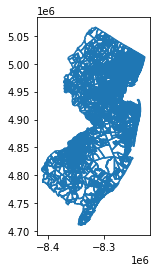

In [33]:
shapefiles_nj.boundary.plot()

In [34]:
print(shapefiles_nj.shape)
vest_shp.shape

(6348, 14)


(6344, 19)

<AxesSubplot:>

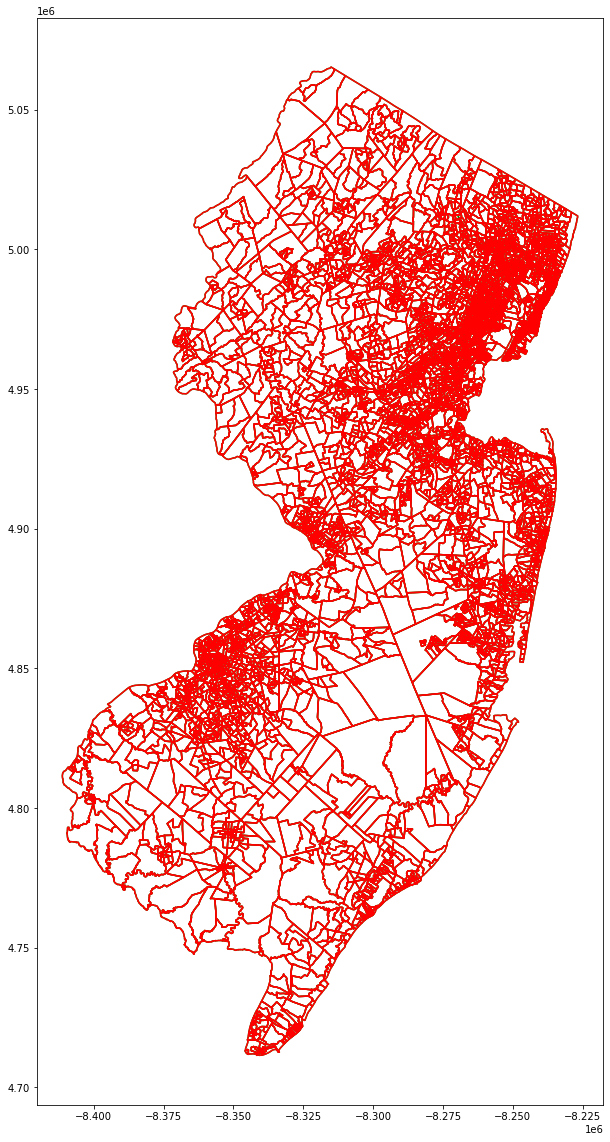

In [35]:
ax = shapefiles_nj.boundary.plot(figsize=(20,20),color="green")
vest_shp.boundary.plot(figsize=(20,20),ax=ax,color="red")

## Complete Merges

VEST- Hudson: Merge Jersey City Ward E 9/24, 6/25; Realign Union City Ward 9 precincts  
Passaic: Merge Pompton Lakes 3/6  

<AxesSubplot:>

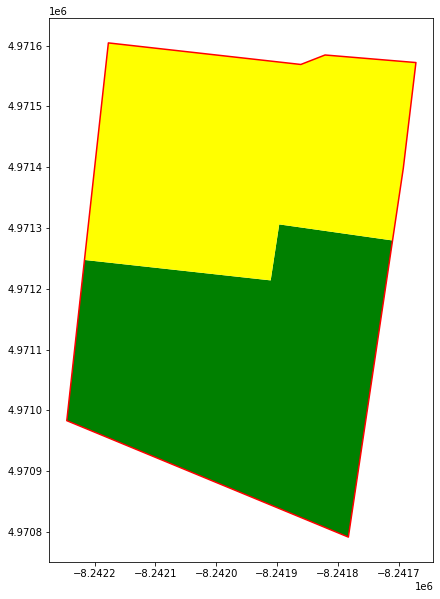

In [36]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '017-0906-E-09'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-09'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-24'].plot(figsize=(10,10),ax=ax,color="yellow")

In [37]:
#Merge precincts in Hudson
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-09"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-24"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-09","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="017-0906-E-24"]

<ipython-input-37-d40cc0d15d90>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

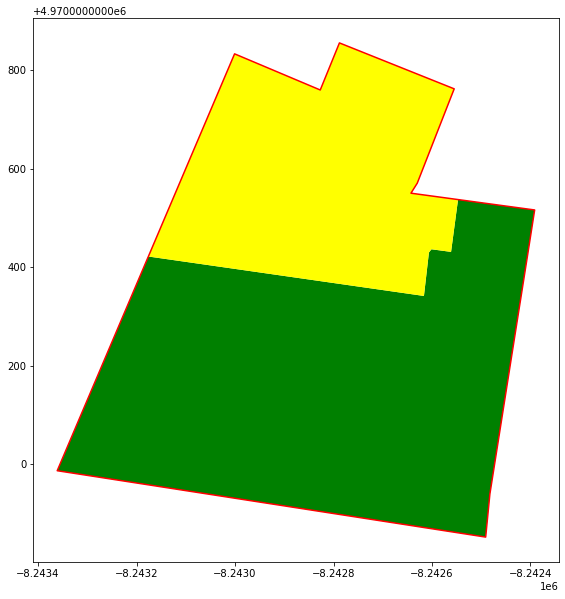

In [38]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '017-0906-E-06'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-06'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '017-0906-E-25'].plot(figsize=(10,10),ax=ax,color="yellow")

In [39]:
#Merge precincts in Hudson
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-06"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-25"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="017-0906-E-06","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="017-0906-E-25"]

<ipython-input-39-7886eb6963d0>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


<AxesSubplot:>

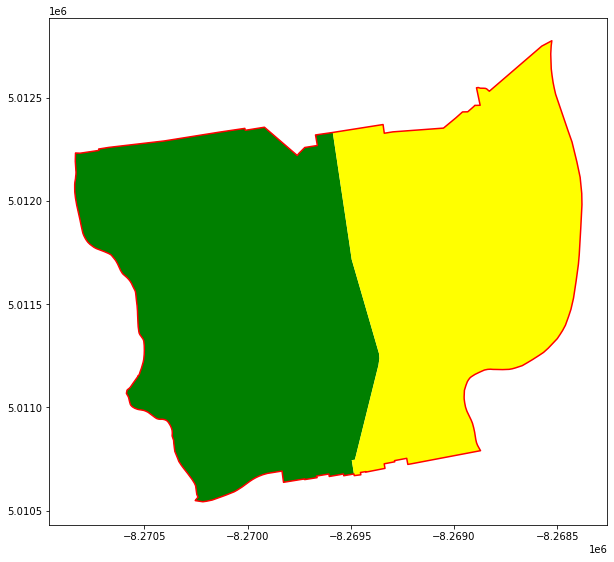

In [40]:
ax = vest_shp[vest_shp['ELECD_KEY'] == '031-1609-00-03'].boundary.plot(figsize=(10,10),color="red")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '031-1609-00-03'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_nj[shapefiles_nj['ELECD_KEY'] == '031-1609-00-06'].plot(figsize=(10,10),ax=ax,color="yellow")

In [41]:
#Merge precincts in Passaic
prec2combine = [shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="031-1609-00-03"],shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="031-1609-00-06"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_nj.loc[shapefiles_nj["ELECD_KEY"]=="031-1609-00-03","geometry"]=new_fort.unary_union
shapefiles_nj = shapefiles_nj[shapefiles_nj["ELECD_KEY"]!="031-1609-00-06"]

<ipython-input-41-2f50c89ceaa5>:3: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)


In [42]:
final_merge = pd.merge(shapefiles_nj,vest_shp,how="outer",on="ELECD_KEY",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          6343
left_only        2
right_only       1
Name: final_merge, dtype: int64

In [43]:
final_merge[final_merge["final_merge"] != 'both'][['COUNTY_x','MUN_NAME_x','COUNTY_y','MUN_NAME_y','ELECD_KEY']]

,COUNTY_x,MUN_NAME_x,COUNTY_y,MUN_NAME_y,ELECD_KEY
2202,Hudson,Union City,NaN,NaN,017-0910-09-05
5975,Hudson,Union City,NaN,NaN,017-0910-09-06
6345,NaN,NaN,MONMOUTH,Middletown Township,000-0000-00-00


In [44]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     6334
False       9
dtype: int64


In [ ]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .5):
        count += 1
        name = source_geoms.iat[i,3]
        county = source_geoms.iat[i,1]
        
        print(str(count)+") For " + str(county) + '-' + str(name) + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and 0.1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between 0.1 and 0.5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between 0.5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")